<img src="header-segmentation.png"/>

# Running the notebook

This notebook assumes the following tree, for loading data and writing results:

```bash
├───data
│   ├───processed
│   │   ├───df_cust.pkl
│   │   └───payment_types_ratio_cols_all_cards.pkl
│   │
│   └───raw
│
└───notebooks
    ├───1_exploration.ipynb
    ├───2_segmentation.ipynb
    ├───3_drifting.ipynb
    ├───Ara.png
    ├───Brazil-regions-states.jpg
    ├───header-drifting.png
    ├───header-exploration.png
    ├───header-segmentation.png
    └───TableLinkeage.png
```

The `*.pkl` files come from running the `1_exploration.ipynb` notebook.

# Project initialization

In [1]:
# Math & data
import numpy as np
import pandas as pd
import pickle

# Graphics
import matplotlib.pyplot as plt
from matplotlib import cycler
import seaborn as sns

# ML
from sklearn.decomposition import PCA
from sklearn import manifold

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer, silhouette_visualizer

In [15]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

import DisplotData
import DisplotML
from DisplotData import bcolors
from DisplotData import print_debug

In [3]:
HAVE_TIME = True # To run the long computations

In [4]:
DEBUG_LEVEL = 0

# Loading data

In [5]:
data_raw_dir = '../data/raw/'
data_processed_dir = '../data/processed/'

In [6]:
file = open(data_processed_dir+'df_cust.pkl','rb')
df_cust = pickle.load(file)
file.close()

file = open(data_processed_dir+'payment_types_ratio_cols_all_cards.pkl','rb')
payment_types_ratio_cols_all_cards = pickle.load(file)
file.close()

# RFM modeling

The resource webinar discusses RFM (Recency, Frequency, Amount) segmentation. Before moving on to the one based on the variables identified by the PCA experimental design, let's start with this one.

## PCA

We start by looking at what the 3 variables R, F, M give in terms of principal components.

In [7]:
feat_cols_RFM = ['total_amount', 'nb_orders', 'order_purchase_recency_01d']

In [8]:
scaler = StandardScaler #MinMaxScaler
n_comp_RFM = len(feat_cols_RFM)
n_plans_RFM = [(2*k, 2*k+1) for k in range((n_comp_RFM//2))]

X_RFM = df_cust[feat_cols_RFM].values
sc = scaler().fit(X_RFM)
X_RFM_scaled = sc.transform(X_RFM)

# Principales components
pca_RFM = PCA(n_components=n_comp_RFM)
pca_RFM.fit(X_RFM_scaled)
X_RFM_proj = pca_RFM.transform(X_RFM_scaled)

In [9]:
title_prefix = str(feat_cols_RFM)+' : '
title_suffix = ' - '+scaler.__name__

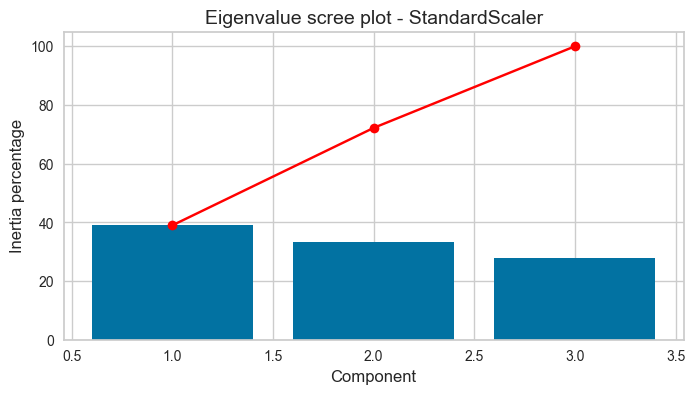

In [10]:
# Scree plot
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
DisplotML.display_scree_plot(pca_RFM, title_suffix=' - '+scaler.__name__)

The 3 variables R, F, M are relatively well balanced in terms of contribution to the total variance. Hence the interest of this standard methodology.

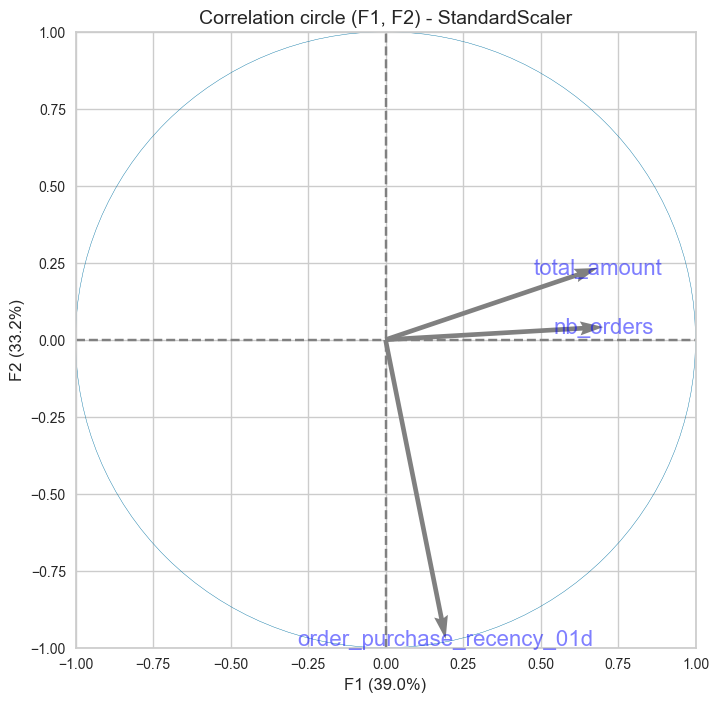

In [11]:
# Cercle of correlations
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
pcs_RFM = pca_RFM.components_
DisplotML.display_circles(pcs_RFM, n_comp_RFM, pca_RFM, n_plans_RFM, labels=np.array(feat_cols_RFM),
                          label_size=16, title_suffix=' - '+scaler.__name__)

The total amount and order frequency (here the number of orders in 20 months) are well correlated. The other dimension is recency of purchase.

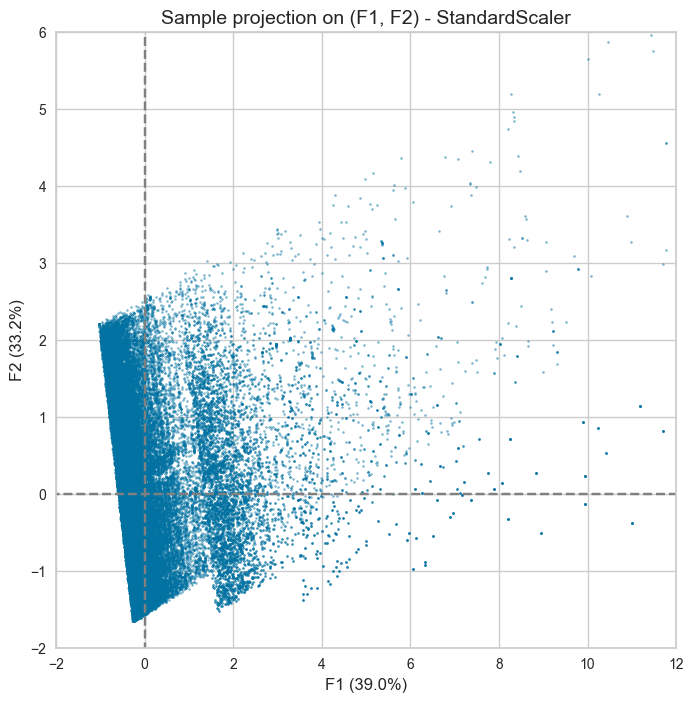

In [12]:
# Sample projections
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
illus_var = None
nn = None
X_RFM_proj_nn = X_RFM_proj[0:nn, :]
DisplotML.display_factorial_planes(X_RFM_proj_nn, n_comp_RFM, pca_RFM, n_plans_RFM, alpha=0.5, labels=None,
                                   marker='o', s=2, illustrative_var=illus_var,
                                   # (F1,F2) : # (F3,F4): # (F5,F6) : xlim=[-3.,7.5], ylim=[-5.,5.5]
                                   xlim=[-2., 12.], ylim=[-2., 6.],
                                   title_suffix=' - '+scaler.__name__)

Groups of individuals are emerging, but the clustering algorithms still have to give the same result...

## t-SNE

We also try the reduction of dimensions by the t-SNE algorithm:

In [16]:
if HAVE_TIME:
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=1500, init='pca', learning_rate='auto')
    X_RFM_tsne = tsne.fit_transform(X_RFM_scaled)
    %store X_RFM_tsne
else:
    %store -r X_RFM_tsne

Stored 'X_RFM_tsne' (ndarray)


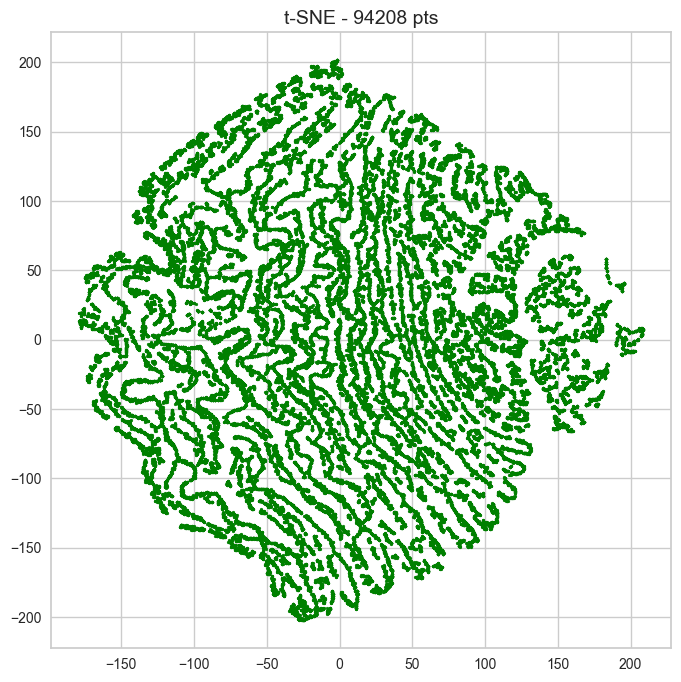

In [17]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

fig = plt.figure()
plt.scatter(X_RFM_tsne[:, 0], X_RFM_tsne[:, 1], s=4, c='green')
plt.title(f't-SNE - {X_RFM_tsne.shape[0]} pts');

## k-Means

### Determination of the optimal number of clusters by the elbow method

In [18]:
inertia_RFM = []
n_range = range(2, 26, 1)
for n_clusters in n_range:
    print(f"n_clusters = {n_clusters}...")
    mdl_kmeans = KMeans(n_clusters=n_clusters)
    mdl_kmeans.fit(X_RFM_scaled)
    labels_kmeans = mdl_kmeans.predict(X_RFM_scaled)
    
    # Inertia
    inertia_RFM.append(mdl_kmeans.inertia_)

n_clusters = 2...
n_clusters = 3...
n_clusters = 4...
n_clusters = 5...
n_clusters = 6...
n_clusters = 7...
n_clusters = 8...
n_clusters = 9...
n_clusters = 10...
n_clusters = 11...
n_clusters = 12...
n_clusters = 13...
n_clusters = 14...
n_clusters = 15...
n_clusters = 16...
n_clusters = 17...
n_clusters = 18...
n_clusters = 19...
n_clusters = 20...
n_clusters = 21...
n_clusters = 22...
n_clusters = 23...
n_clusters = 24...
n_clusters = 25...


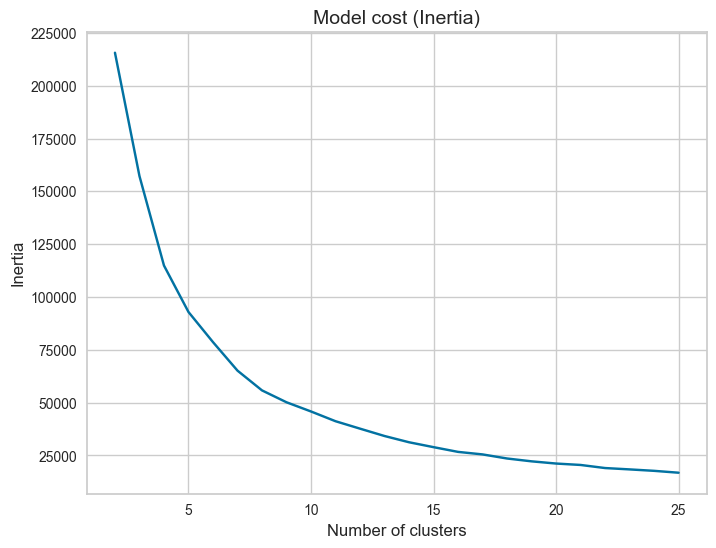

In [19]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig = plt.figure()
plt.plot(n_range,inertia_RFM)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');
plt.title('Model cost (Inertia)')
plt.grid('on')
plt.show()

We see an elbow in $k$ = 4, 5 and another in $k$ = 7, let's see which value is more appropriate with the silhouette method.

### With silhouette coefficients

In [20]:
HAVE_TIME = False

For n_clusters = 2, average silhouette_score : 0.39316918934456063


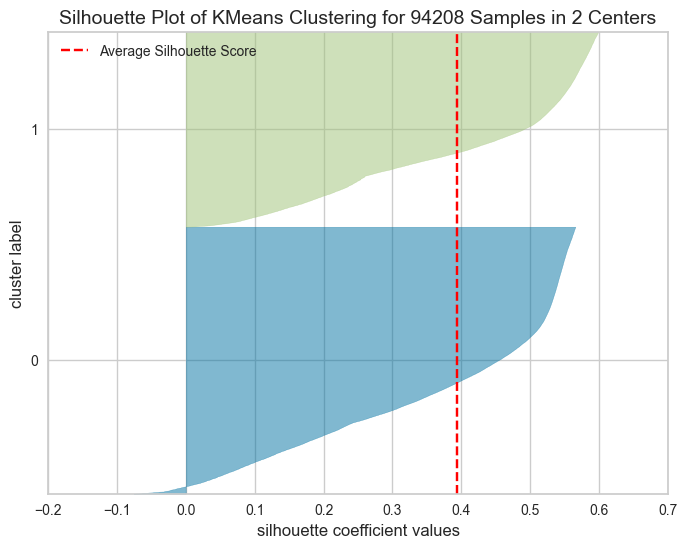

For n_clusters = 3, average silhouette_score : 0.4538181444725028


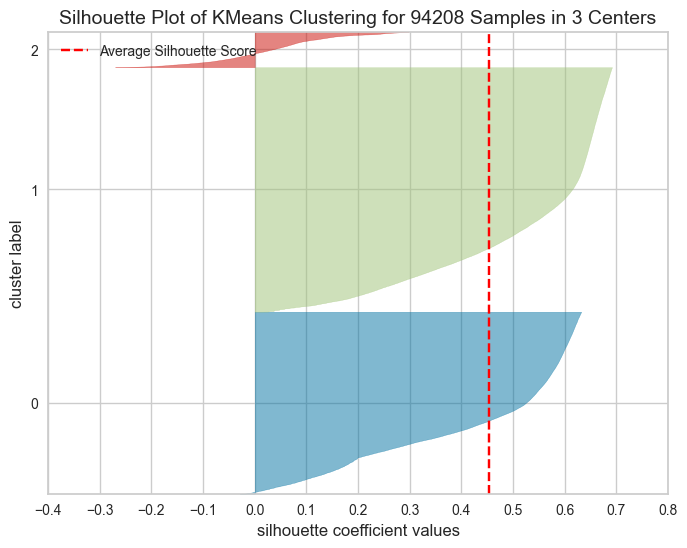

For n_clusters = 4, average silhouette_score : 0.48162197616568464


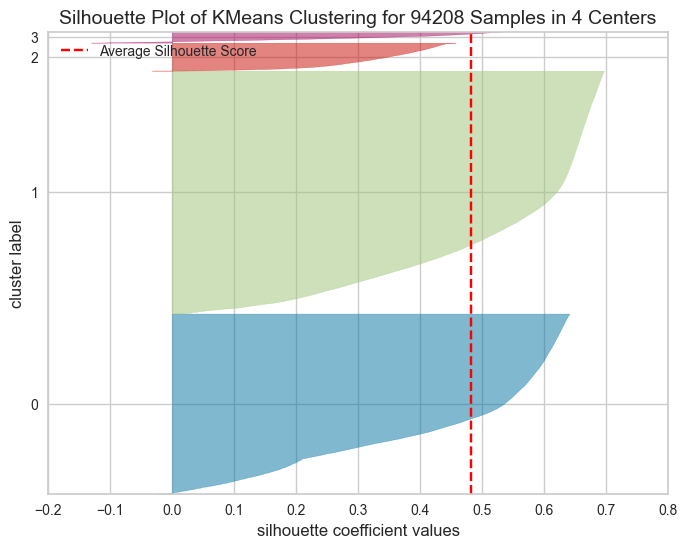

For n_clusters = 5, average silhouette_score : 0.4858564879840827


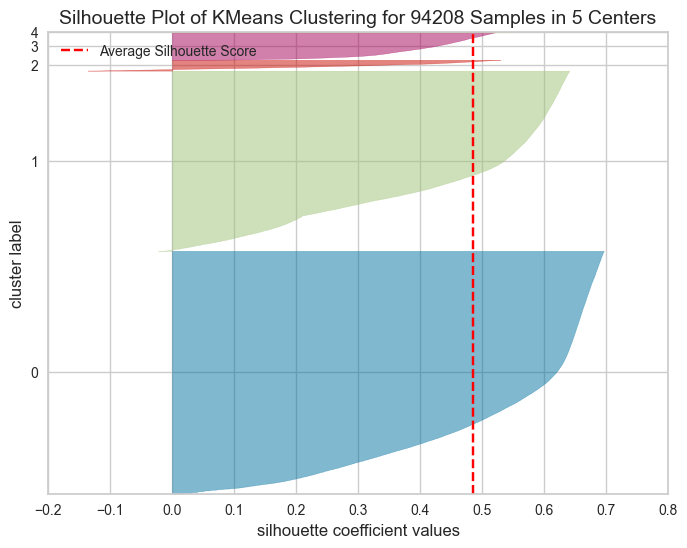

For n_clusters = 6, average silhouette_score : 0.41940775676573516


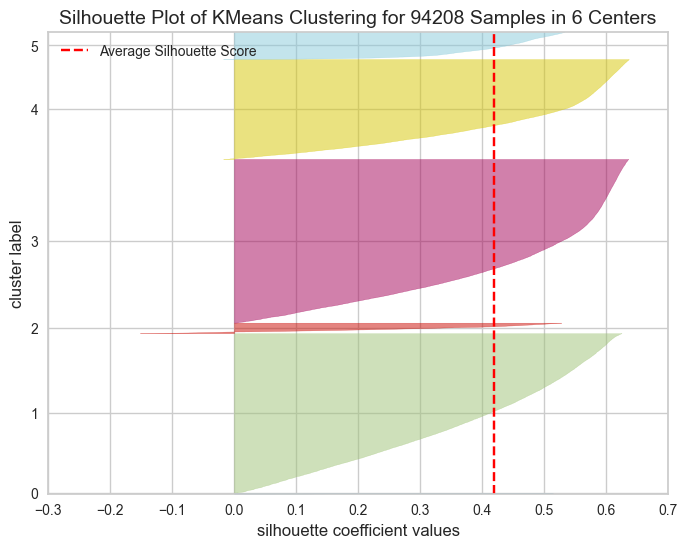

For n_clusters = 7, average silhouette_score : 0.43525291925689774


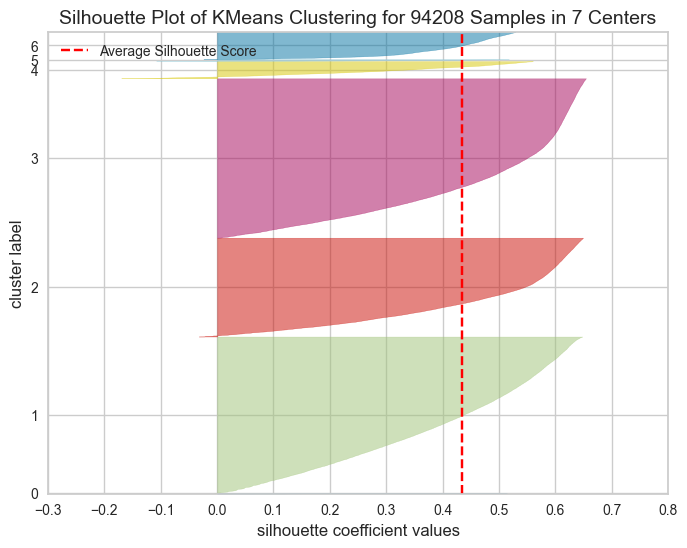

For n_clusters = 8, average silhouette_score : 0.4396479248385848


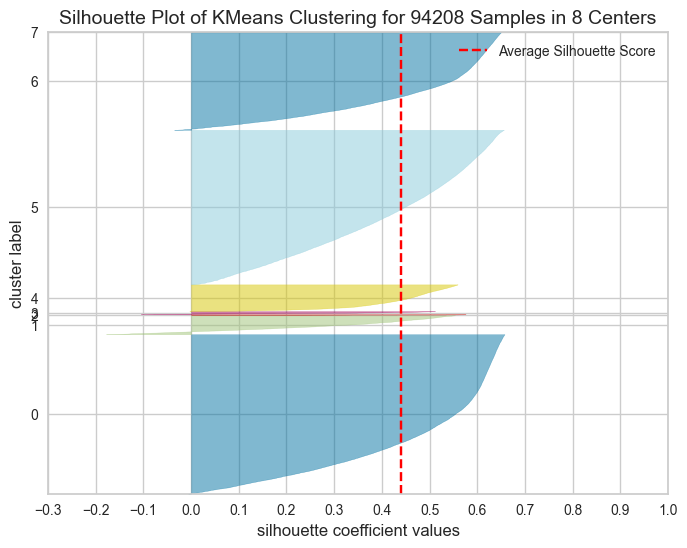

In [36]:
n_range = range(2, 9, 1)
for n_clusters in n_range:
    mdl_kmeans = KMeans(n_clusters=n_clusters)
    mdl_kmeans.fit(X_RFM_scaled)
    labels_kmeans = mdl_kmeans.predict(X_RFM_scaled)
    
    # Silhouette
    silhouette_avg = silhouette_score(X_RFM_scaled, labels_kmeans)
    print(f"For n_clusters = {n_clusters}, average silhouette_score : {silhouette_avg}")
    if HAVE_TIME:
        # Instantiate the clustering model and visualizer
        silhouette_visualizer(mdl_kmeans, X_RFM_scaled, colors='yellowbrick')
        plt.show()


With 5 clusters, the silhouette coefficient is maximum, which corresponds to an elbow of the elbow method.

### Clustering stability

The KMeans algorithm initializes the centroids randomly (unless we force the randomness), running the same algorithm several times allows you to see if the number of clusters chosen and the dataset gives stable clustering.

In [21]:
def compute_clustering_stability(X_scaled, n_tries, n_clusters):
    """Evaluates the stability of a clustering model.
    
    Restart clustering with the same algo (without setting random_state), compare all combinations
    of labels and evaluates and averages the ARI scores.
    
    Parameters
    ----------
    X_scaled: numpy.arry
        Matrix of the clustering problem.
    n_tries: int
        Number of models relaunched.
    n_clusters: int
        Number of model clusters.

    Returns
    -------
    mean_score_ARI: float
        Average ARI score.
    """
    models_kmeans = {}
    labels_kmeans = {}
    scores_ARI = []
    for ind in range(n_tries):
        # Clustering
        mdl = KMeans(n_clusters=n_clusters, n_init=1, init='random')
        mdl.fit(X_scaled)
        lbls = mdl.predict(X_scaled)

        # Comparaison with previous clusters
        for ind2 in labels_kmeans:
            lbls2 = labels_kmeans[ind2]
            c = adjusted_rand_score(lbls, lbls2)
            print_debug((ind, ind2, c), 1, DEBUG_LEVEL)
            scores_ARI.append(c)

        models_kmeans[ind] = mdl
        labels_kmeans[ind] = lbls

    mean_score_ARI = (np.array(scores_ARI)).mean()
    return mean_score_ARI

In [22]:
n_tries = 10
n_range = range(2,10,1)
for n_clusters in n_range:
    mean_score_ARI_RFM = compute_clustering_stability(X_RFM_scaled, n_tries, n_clusters)
    print(f"n_clusters = {n_clusters} : average ARI score: {mean_score_ARI_RFM:.3f}")

n_clusters = 2 : average ARI score: 0.792
n_clusters = 3 : average ARI score: 1.000
n_clusters = 4 : average ARI score: 0.988
n_clusters = 5 : average ARI score: 0.736
n_clusters = 6 : average ARI score: 0.691
n_clusters = 7 : average ARI score: 0.801
n_clusters = 8 : average ARI score: 0.720
n_clusters = 9 : average ARI score: 0.811


### Segmentation

In [23]:
n_clusters_RFM = 5

In [24]:
mdl_kmeans_RFM = KMeans(n_clusters=n_clusters_RFM, n_init=100, init='random', random_state=18011975)
mdl_kmeans_RFM.fit(X_RFM_scaled)
labels_kmeans_RFM = mdl_kmeans_RFM.predict(X_RFM_scaled)

### Clusters description

In [25]:
df_cust['label_RFM'] = mdl_kmeans_RFM.labels_

In [26]:
np.unique(mdl_kmeans_RFM.labels_)

array([0, 1, 2, 3, 4])

In [27]:
df_cust_clusters_RFM = pd.DataFrame(
    df_cust.groupby(['label_RFM'])[feat_cols_RFM].mean(), columns=feat_cols_RFM
).reset_index()
count_col_RFM = pd.DataFrame(df_cust.groupby(['label_RFM'])['total_amount'].count()).reset_index()
df_cust_clusters_RFM['count'] = count_col_RFM['total_amount']
df_cust_clusters_RFM.sort_values(by='order_purchase_recency_01d', ascending=True)

,label_RFM,total_amount,nb_orders,order_purchase_recency_01d,count
2,2,114.709041,1.000000,150.915152,20295
4,4,114.036386,1.000000,350.764158,32560
0,0,1187.879962,1.097928,374.438324,2124
3,3,234.335660,2.241186,387.322926,5701
1,1,115.130123,1.000000,518.254772,33528


**Comments:**
If we rank customers in ascending order of purchase recency on the platform (the higher the recency, the more recent the last purchase):
- The 2nd group is clearly higher in terms of **total turnover** (1171), and with relatively few customers (a kind of "niche").
- The 4th group also has a higher turnover (661) than the other groups, with even fewer customers, but with **many more orders made (7.3)**, which also constitutes a niche.
- The 5th group (that of the most recent customers) has **the lowest turnover**, which should alert the platform to the financial profile of these customers. It is, however, the **largest** group in number of customers.

In [28]:
desc_cols = feat_cols_RFM+['count']
df_desc_RFM_sc = MinMaxScaler().fit_transform(df_cust_clusters_RFM[desc_cols])

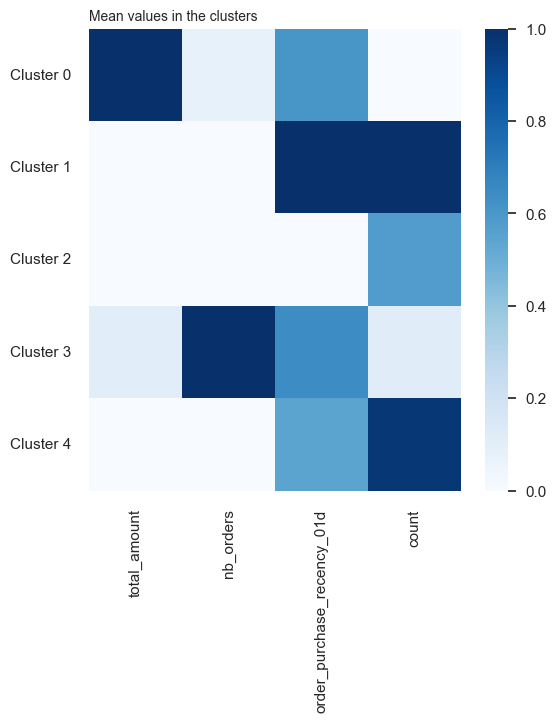

In [32]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sns.set(font_scale = 2)
sns.set(rc={'figure.facecolor':'white'})
fig, ax = plt.subplots()
desc = sns.heatmap(df_desc_RFM_sc, vmin=0, vmax=1, cmap="Blues", square=False, ax=ax,
                          cbar_kws={'orientation':'vertical', 'pad':0.05, 'shrink':1.}
                          )
desc.set_title('Mean values in the clusters', fontsize=10, loc='left');
desc.set_xticklabels(desc_cols); # , fontsize=16
desc.set_yticklabels([f"Cluster {c}" for c in df_cust_clusters_RFM.index]); # , fontsize=16
plt.xticks(rotation=90); 
plt.yticks(rotation=0);

### Cluster boxplots

In [43]:
yellowbrick.set_aesthetic()

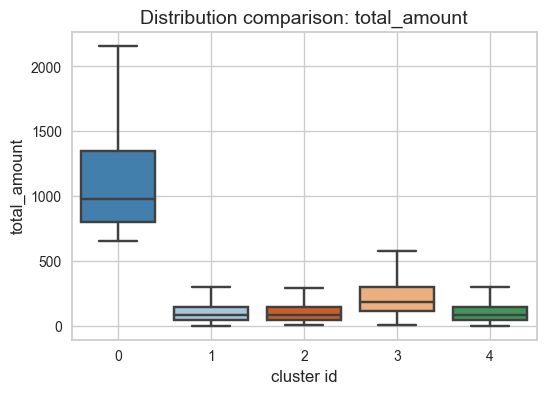

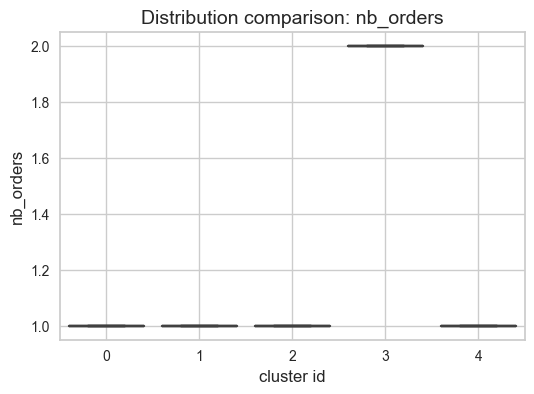

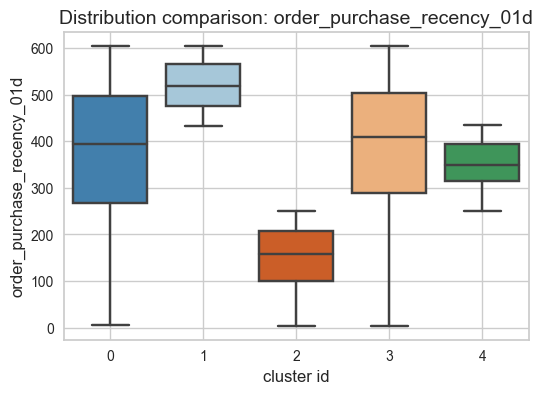

In [44]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
N = 10 #n_clusters #10
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20c(np.linspace(0, 1, N)))
for col in feat_cols_RFM:
    f, ax = plt.subplots()
    sns.boxplot(data=df_cust, x='label_RFM', y=col, width=0.8, showfliers = False) #, palette='prism_r' 'gist_rainbow_r', width=0.8, notch=True, showfliers=True, hue='label_RFM'    plt.grid('on')
    plt.title(f'Distribution comparison: {col}')
    plt.xlabel(f'cluster id')
    plt.ylabel(f'{col}')
    plt.grid('on')

### Cluster radarplots

In [45]:
feat_cols_RFM_2 = feat_cols_RFM + [feat_cols_RFM[0]]
df_cust_clusters_RFM_sc = MinMaxScaler().fit_transform(df_cust_clusters_RFM[feat_cols_RFM])
df_cust_clusters_RFM_sc = np.hstack((df_cust_clusters_RFM_sc, df_cust_clusters_RFM_sc[:, 0].reshape(-1,1)))

[0.         2.0943951  4.1887902  6.28318531]


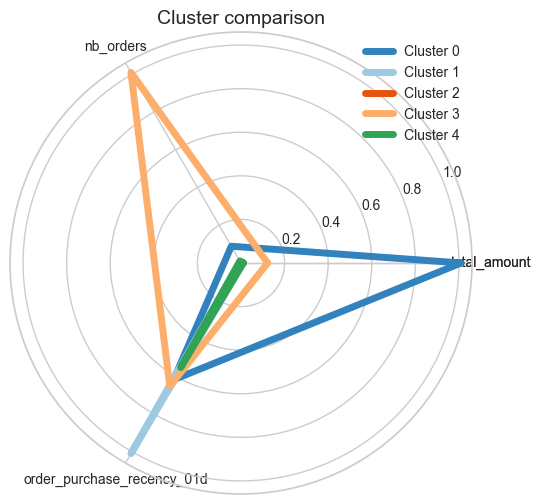

In [46]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

n = len(feat_cols_RFM_2)
all_labels = np.unique(mdl_kmeans_RFM.labels_)
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(feat_cols_RFM_2))
print(label_loc)

plt.figure()
plt.subplot(polar=True)
for lbl in all_labels:
    vals = df_cust_clusters_RFM_sc[lbl,:]+0.01
    plt.plot(np.array(label_loc), vals, label=f"Cluster {lbl}", linewidth=5)
plt.title('Cluster comparison');
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=feat_cols_RFM_2)
plt.legend();
plt.show()

### Visualisation dans les plans de l'ACP

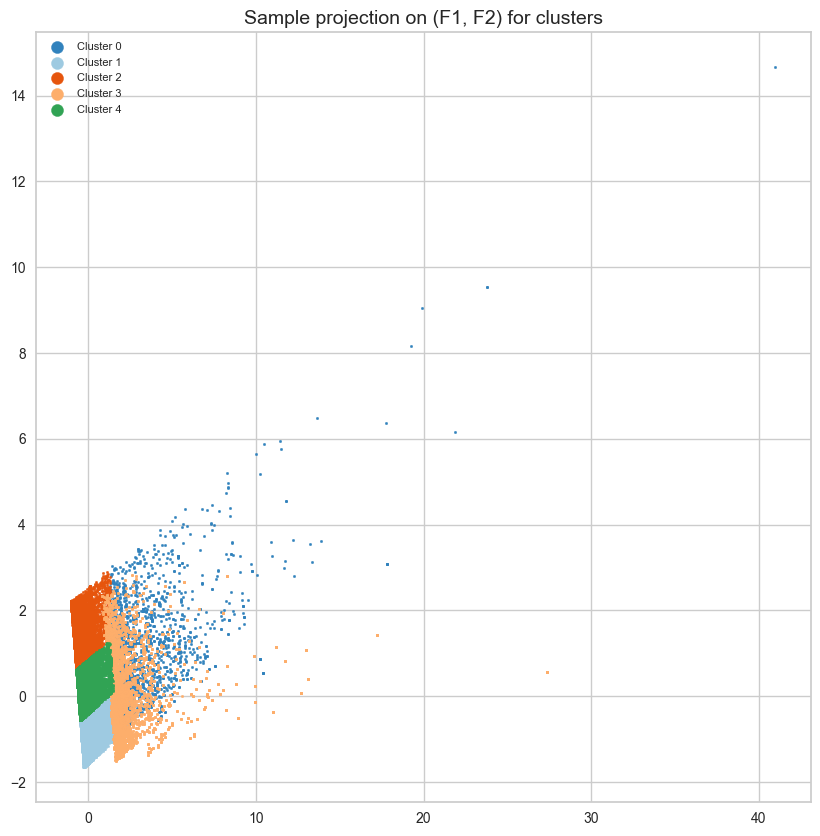

In [50]:
# %matplotlib notebook
%matplotlib inline
cmaps = [plt.cm.tab20c]
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
N = 10
for cm in cmaps:
    cmap = cm
    plt.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))
    for label in np.unique(labels_kmeans_RFM):
        selected = np.where(labels_kmeans_RFM == label)
        plt.scatter(X_RFM_proj[selected, 0], X_RFM_proj[selected, 1], 
                    s=3, label=f"Cluster {label}")
    plt.title('Sample projection on (F1, F2) for clusters')
    plt.legend(prop={'size': 8}, markerscale=5)
    plt.show(block=False)

### Visualisation dans le plan du t-SNE

In [99]:
cmaps = [plt.cm.tab20c]

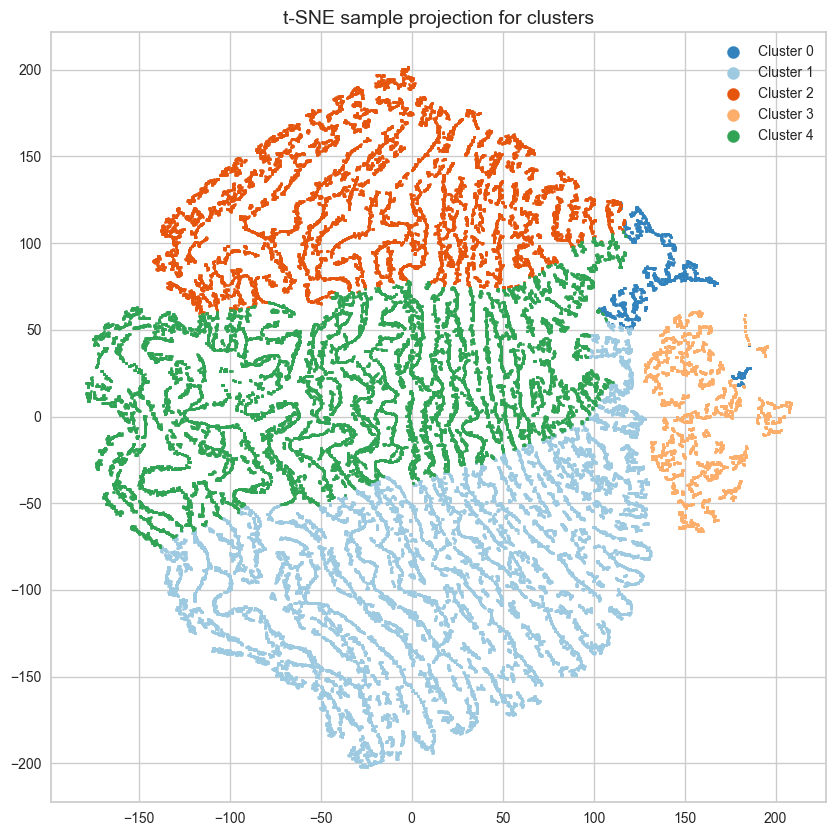

In [51]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
N = 10
for cm in cmaps:
    cmap = cm
    plt.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))
    for label in np.unique(labels_kmeans_RFM):
        selected = np.where(labels_kmeans_RFM == label)
        plt.scatter(X_RFM_tsne[selected, 0], X_RFM_tsne[selected, 1], s=3, label=f"Cluster {label}")
    plt.title('t-SNE sample projection for clusters')
    plt.legend(prop={'size': 10}, markerscale=5)
    plt.show(block=False)

## Hierarchical Agglomerative Classification

The CAH does not pass in memory on the workstation, even by limiting the number of clusters, ie the depth of the tree.

# Other modeling

A partir des résultats du plan d'expériences d'ACP, on choisit le scaler StandardScaler et les variables suivantes :
```
['mean_amount_per_item', 'mean_rev_score', 'payment_installments', 'order_purchase_recency_01d', 'boleto_ratio', 'voucher_ratio', 'all_card_ratio']
```

In [52]:
# num_cols = ['total_amount', 'nb_items',
#             'mean_rev_score',
# #             'payment_installments',
#             ]+payment_types_ratio_cols
# num_cols = ['mean_amount_per_item', 'mean_rev_score', 'payment_installments', 'order_purchase_recency_01d']+payment_types_ratio_cols
# num_cols = ['mean_amount_per_item', 'mean_rev_score', 'payment_installments']+payment_types_ratio_cols_all_cards
num_cols = ['mean_amount_per_item', 'mean_rev_score', 'payment_installments']+payment_types_ratio_cols_all_cards
cat_cols = []
feat_cols = num_cols+cat_cols

scaler = StandardScaler

In [53]:
df_cust.shape

(94208, 58)

In [54]:
df_cust[feat_cols].shape

(94208, 6)

In [55]:
df_cust[feat_cols]

,mean_amount_per_item,mean_rev_score,payment_installments,voucher_ratio,boleto_ratio,all_card_ratio
0,129.90,5.0,8,0.0,0.0,1.0
1,18.90,4.0,1,0.0,0.0,1.0
2,69.00,3.0,8,0.0,0.0,1.0
3,25.99,4.0,4,0.0,0.0,1.0
4,180.00,5.0,6,0.0,0.0,1.0
...,...,...,...,...,...,...
94203,785.00,5.0,10,0.0,0.0,1.0
94204,64.89,4.0,1,0.0,0.0,1.0
94205,89.90,5.0,1,0.0,0.0,1.0
94206,115.00,5.0,5,0.0,0.0,1.0


## PCA

In [56]:
scaler = StandardScaler #MinMaxScaler
n_comp = len(feat_cols)
n_plans = [(2*k, 2*k+1) for k in range((n_comp//2))]

X = df_cust[feat_cols].values
sc = scaler().fit(X)
X_scaled = sc.transform(X)

# Pprincipal components
pca = PCA(n_components=n_comp)
pca.fit(X_scaled)
X_proj = pca.transform(X_scaled)

In [57]:
title_prefix = str(feat_cols)+' : '
title_suffix = ' - '+scaler.__name__

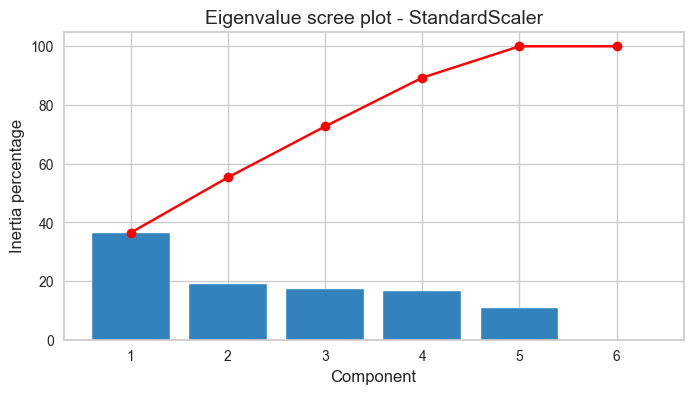

In [59]:
# Scree plot
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
DisplotML.display_scree_plot(pca, title_suffix=' - '+scaler.__name__)

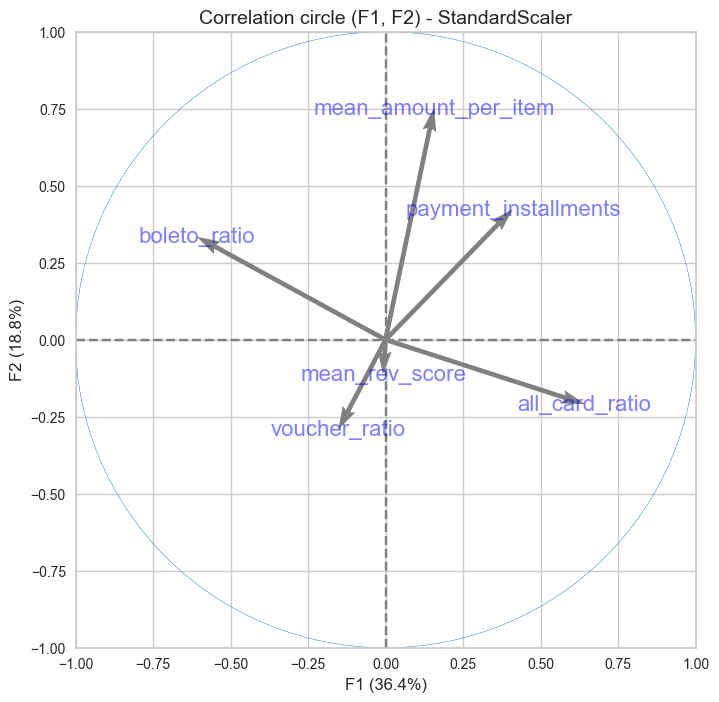

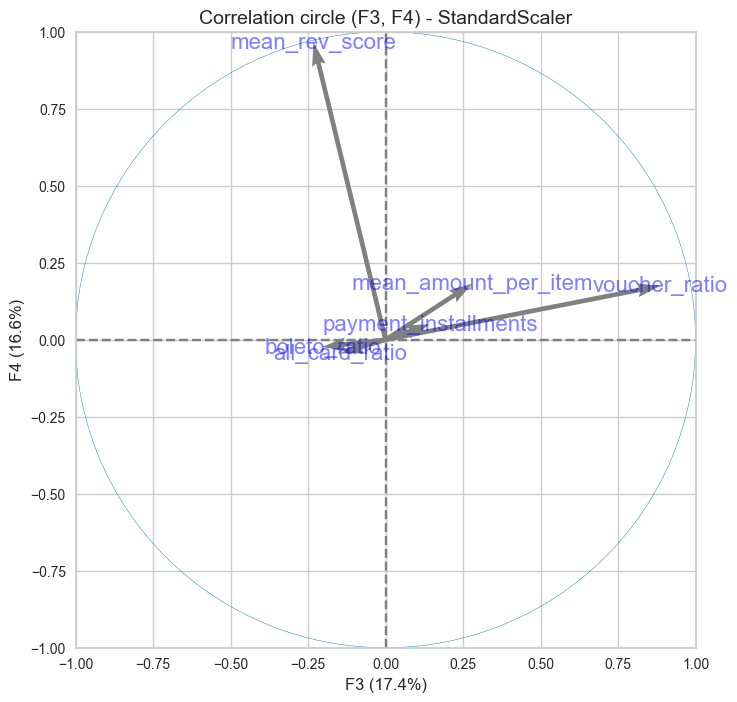

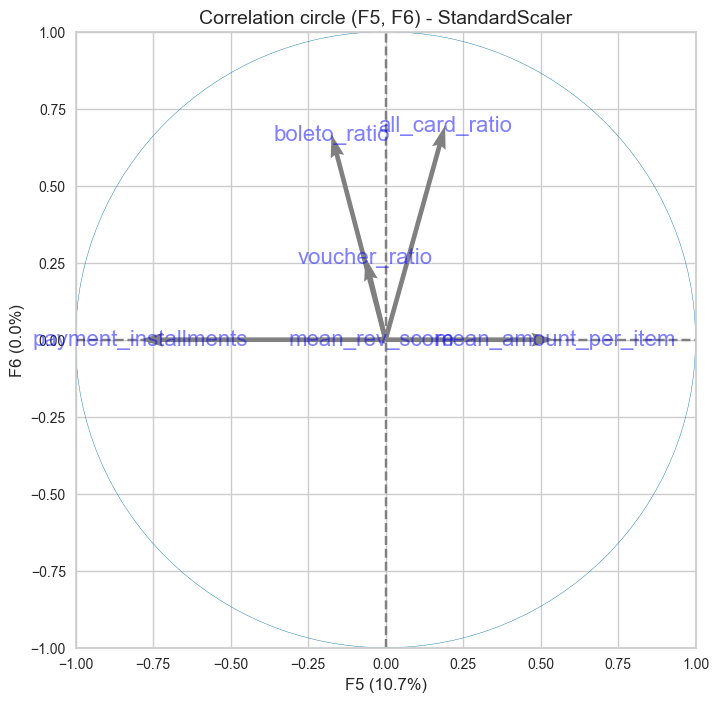

In [61]:
# Circle of correlations
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
pcs = pca.components_
DisplotML.display_circles(pcs, n_comp, pca, n_plans, labels=np.array(feat_cols),
                          label_size=16, title_suffix=' - '+scaler.__name__)

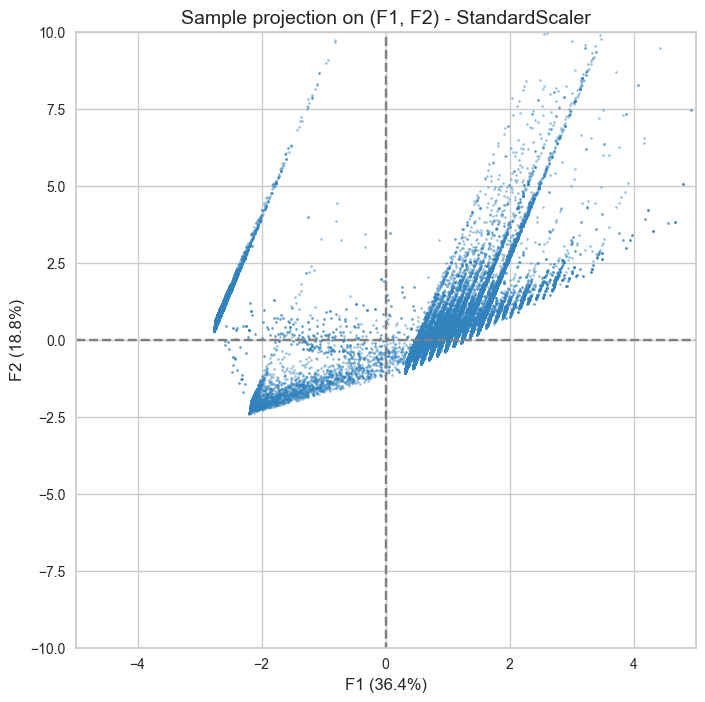

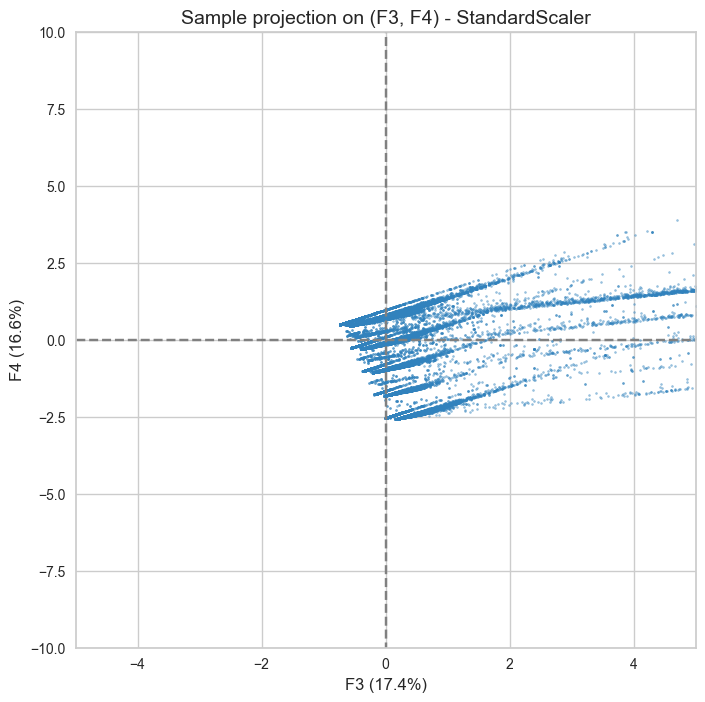

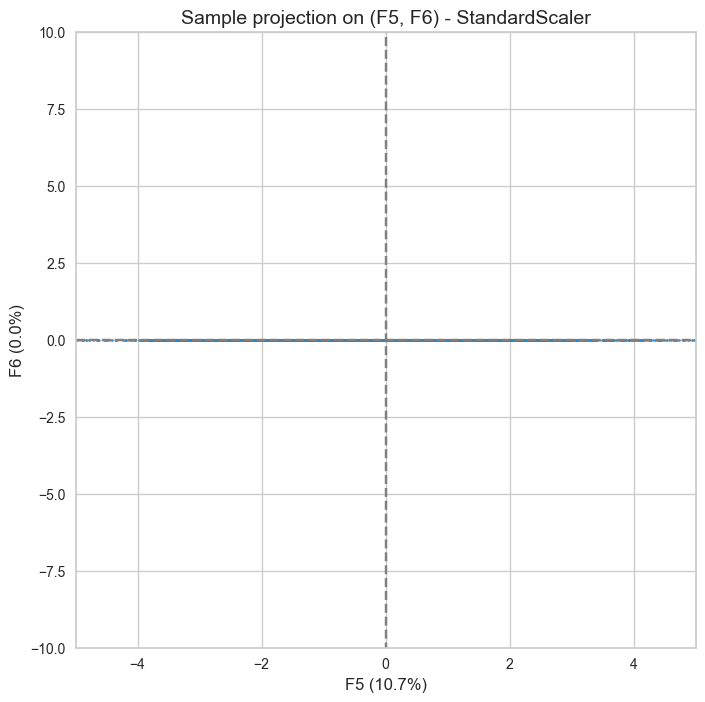

In [63]:
# Sample projections
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
illus_var = None
nn = None
X_proj_nn = X_proj[0:nn, :]
DisplotML.display_factorial_planes(X_proj_nn, n_comp, pca, n_plans, alpha=0.5, labels=None,
                                   marker='o', s=2, illustrative_var=illus_var,
                                   # (F1,F2) : # (F3,F4): # (F5,F6) : xlim=[-3.,7.5], ylim=[-5.,5.5]
                                   xlim=[-5., 5.], ylim=[-10., 10.],
                                   title_suffix=' - '+scaler.__name__)

Groups of individuals are emerging, but the clustering algorithms still have to give the same result...

## t-SNE

On tente également la réduction de dimensions par l'algorithme t-SNE :

In [64]:
HAVE_TIME = True

In [66]:
if HAVE_TIME:
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=1500, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_scaled)
    %store X_tsne
else:
    %store -r X_tsne

Stored 'X_tsne' (ndarray)


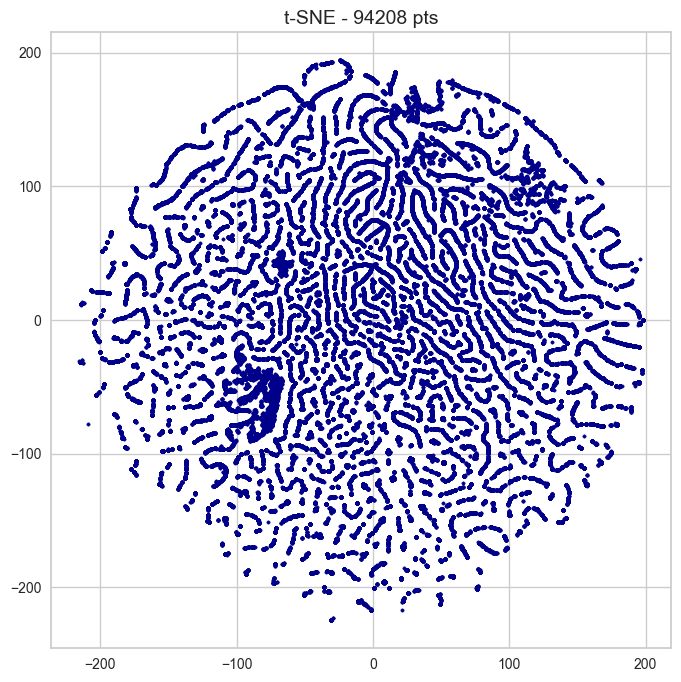

In [68]:
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig = plt.figure()
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=6, c='darkblue')
plt.title(f't-SNE - {X_tsne.shape[0]} pts');

## k-Means

### Determination of the optimal number of clusters by the elbow method

In [69]:
inertia = []
n_range = range(2, 26, 1)
for n_clusters in n_range:
    print(f"n_clusters = {n_clusters}...")
    mdl_kmeans = KMeans(n_clusters=n_clusters)
    mdl_kmeans.fit(X_scaled)
    labels_kmeans = mdl_kmeans.predict(X_scaled)
    
    # Inertia
    inertia.append(mdl_kmeans.inertia_)

n_clusters = 2...
n_clusters = 3...
n_clusters = 4...
n_clusters = 5...
n_clusters = 6...
n_clusters = 7...
n_clusters = 8...
n_clusters = 9...
n_clusters = 10...
n_clusters = 11...
n_clusters = 12...
n_clusters = 13...
n_clusters = 14...
n_clusters = 15...
n_clusters = 16...
n_clusters = 17...
n_clusters = 18...
n_clusters = 19...
n_clusters = 20...
n_clusters = 21...
n_clusters = 22...
n_clusters = 23...
n_clusters = 24...
n_clusters = 25...


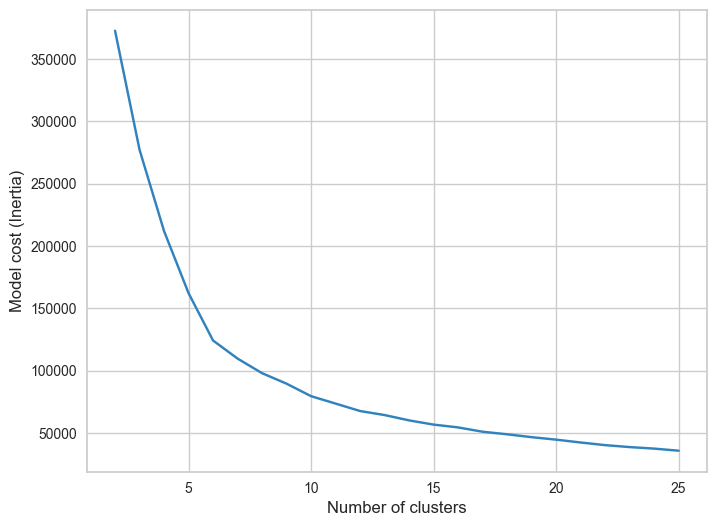

In [71]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig = plt.figure()
plt.plot(n_range,inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Model cost (Inertia)');
plt.grid('on')
plt.show()

We see a bend at k = 6, let's confirm this value with the silhouette method.
<span class="mark">k = 7 without merging maps, or with recency</span>

### With silhouette coefficients

With YellowBrick:

For n_clusters = 2, the average silhouette_score is : 0.5325658931149281


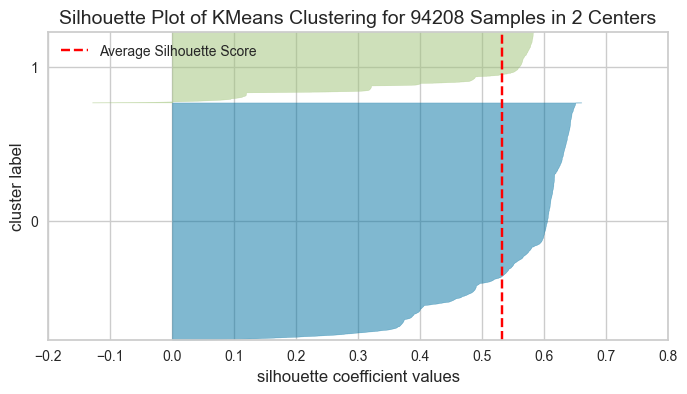

For n_clusters = 3, the average silhouette_score is : 0.5592040611208492


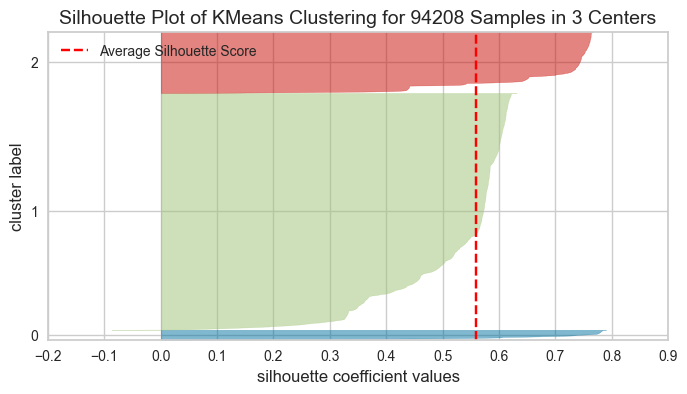

For n_clusters = 4, the average silhouette_score is : 0.5161107449577338


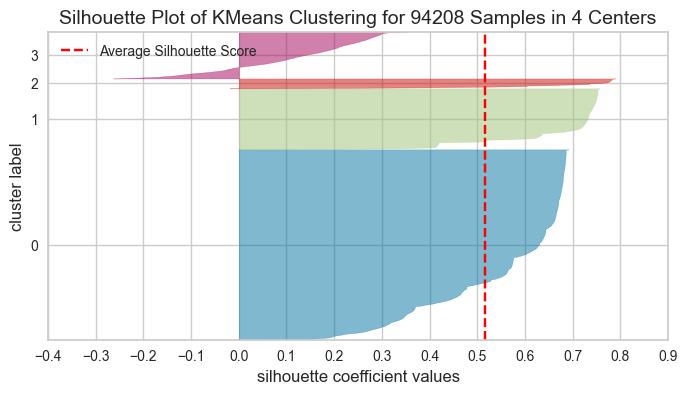

For n_clusters = 5, the average silhouette_score is : 0.5216003463719021


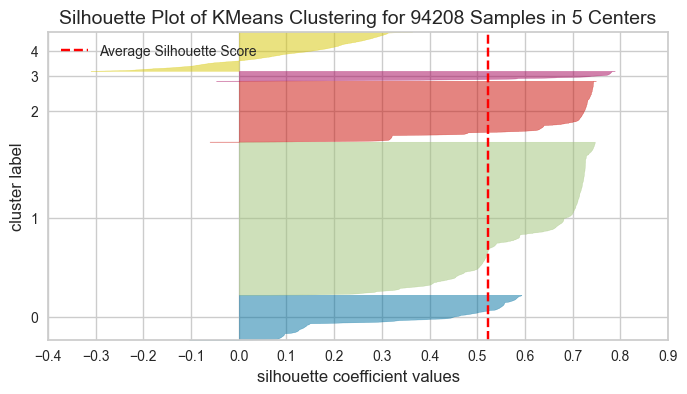

For n_clusters = 6, the average silhouette_score is : 0.5280237859528789


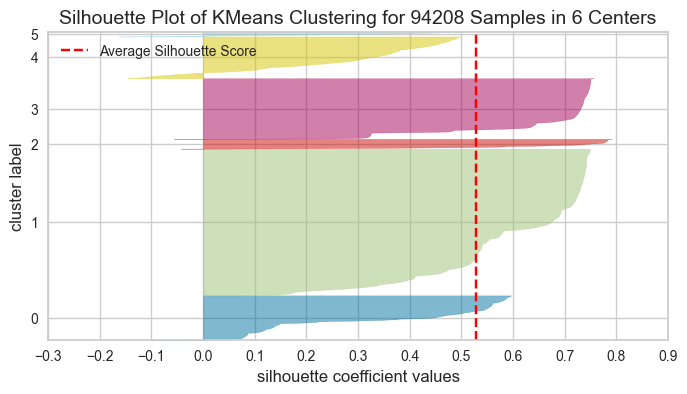

For n_clusters = 7, the average silhouette_score is : 0.5227939911215715


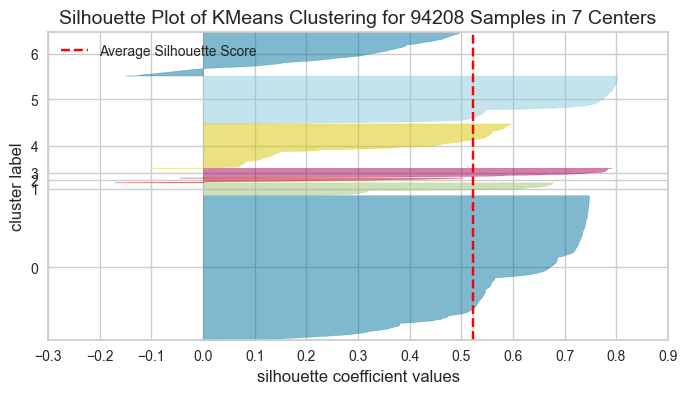

For n_clusters = 8, the average silhouette_score is : 0.5265707373853817


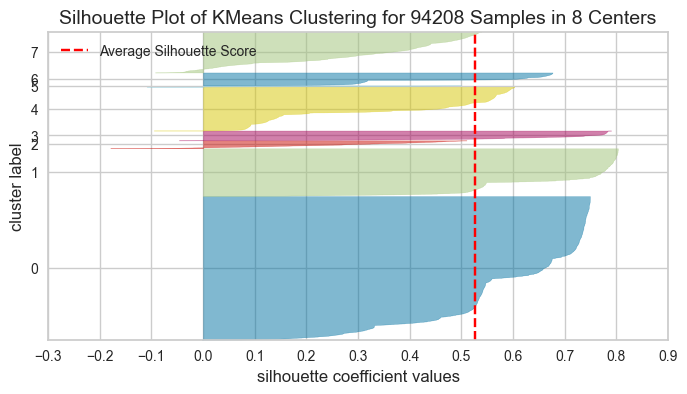

For n_clusters = 9, the average silhouette_score is : 0.5029920527416197


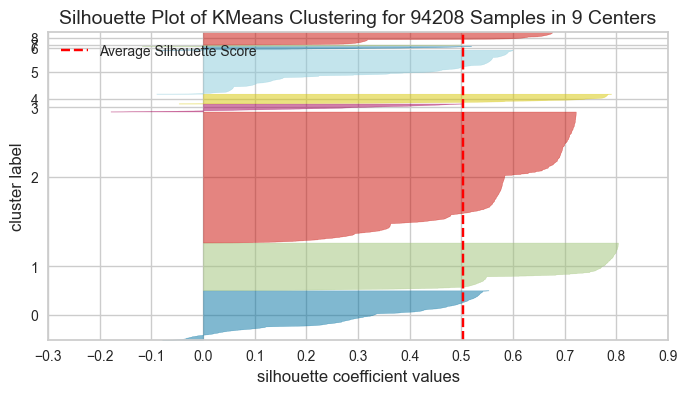

In [73]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

n_range = range(2, 10, 1)
for n_clusters in n_range:
    mdl_kmeans = KMeans(n_clusters=n_clusters)
    mdl_kmeans.fit(X_scaled)
    labels_kmeans = mdl_kmeans.predict(X_scaled)
    
    # Silhouette
    silhouette_avg = silhouette_score(X_scaled, labels_kmeans)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")
    if HAVE_TIME:
        # Instantiate the clustering model and visualizer
        silhouette_visualizer(mdl_kmeans, X_scaled, colors='yellowbrick')


Even if the best silhouette score is for $k$=3, we prefer to push the number of customer groups more, to $k$=6, given our number of variables.

### Clustering stability

The KMeans algorithm initializes the centroids randomly (unless we force the randomness), running the same algorithm several times allows you to see if the number of clusters chosen and the dataset gives stable clustering.

In [74]:
n_tries = 10
n_range = range(2,10,1)
for n_clusters in n_range:
    mean_score_ARI = compute_clustering_stability(X_scaled, n_tries, n_clusters)
    print(f"n_clusters = {n_clusters} : average ARI score : {mean_score_ARI:.3f}")

n_clusters = 2 : average ARI score : 0.777
n_clusters = 3 : average ARI score : 0.671
n_clusters = 4 : average ARI score : 0.718
n_clusters = 5 : average ARI score : 0.721
n_clusters = 6 : average ARI score : 0.722
n_clusters = 7 : average ARI score : 0.742
n_clusters = 8 : average ARI score : 0.705
n_clusters = 9 : average ARI score : 0.708


In [75]:
n_tries = 10
n_range = range(2,10,1)
for n_clusters in n_range:
    mean_score_ARI = compute_clustering_stability(X_scaled, n_tries, n_clusters)
    print(f"n_clusters = {n_clusters} : average ARI score : {mean_score_ARI:.3f}")

n_clusters = 2 : average ARI score : 0.759
n_clusters = 3 : average ARI score : 0.533
n_clusters = 4 : average ARI score : 0.704
n_clusters = 5 : average ARI score : 0.815
n_clusters = 6 : average ARI score : 0.800
n_clusters = 7 : average ARI score : 0.728
n_clusters = 8 : average ARI score : 0.690
n_clusters = 9 : average ARI score : 0.707


The stability of KMeans clustering is maximal for *k* = 6.

### Final clustering

In [76]:
if 'order_purchase_recency_01d' in feat_cols:
    n_clusters = 7
else:
    n_clusters = 6

In [77]:
mdl_kmeans = KMeans(n_clusters=n_clusters, n_init=100, init='random', random_state=18011975)
mdl_kmeans.fit(X_scaled)
labels_kmeans = mdl_kmeans.predict(X_scaled)

#### Variant 'elkan'

In [78]:
mdl_kmeans_elkan = KMeans(algorithm='elkan', n_clusters=n_clusters, n_init=100, init='random', random_state=18011975)
mdl_kmeans_elkan.fit(X_scaled)
labels_kmeans_elkan = mdl_kmeans_elkan.predict(X_scaled)

In [104]:
c = adjusted_rand_score(labels_kmeans, labels_kmeans_elkan)
print(c)

1.0


The `elkan` variant does not modify the segmentation, in our case.

### Description des clusters

In [79]:
df_cust['label'] = labels_kmeans

In [80]:
df_cust_clusters = pd.DataFrame(df_cust.groupby(['label'])[feat_cols].mean(), columns=feat_cols).reset_index()
count_col = pd.DataFrame(df_cust.groupby(['label'])['mean_rev_score'].count()).reset_index()
df_cust_clusters['count'] = count_col['mean_rev_score']
df_cust_clusters.sort_values(by='mean_amount_per_item', ascending=False)

,label,mean_amount_per_item,mean_rev_score,payment_installments,voucher_ratio,boleto_ratio,all_card_ratio,count
4,4,1234.547649,4.114926,6.932025,0.006899,0.095305,0.897796,1427
5,5,193.929027,4.520247,9.046775,0.004000,0.001320,0.994680,12806
1,1,104.916810,1.871795,3.212164,0.002547,0.001055,0.996399,13565
2,2,97.248636,4.157107,1.007498,0.000503,0.996592,0.002904,18538
3,3,90.152651,4.745631,2.266108,0.002012,0.001709,0.996279,44869
0,0,86.633843,4.124281,1.193473,0.880060,0.003779,0.116161,3003


**Comments:**
If we classify the customers in descending order of their purchase amount per item, on the platform:
- The first group is clearly higher in **average turnover**, and with **few customers** (sort of "niche")
- The first 3 groups pay by **payment/credit card** (but the penultimate also). They are also the ones who **split** their payment the most.
- The first 2 are **satisfied** with their purchases (grade > 4/5), the **3rd not really**.
- The 4th group is distinguished by the fact of paying in cash ("boleto")
- The 5th group is the **most satisfied**, and paid by credit card.
- The 6th group is the group that pays mainly in **coupons**. The amount of purchases is affected.

In [81]:
desc_cols = feat_cols+['count']
df_desc_sc = MinMaxScaler().fit_transform(df_cust_clusters[desc_cols])

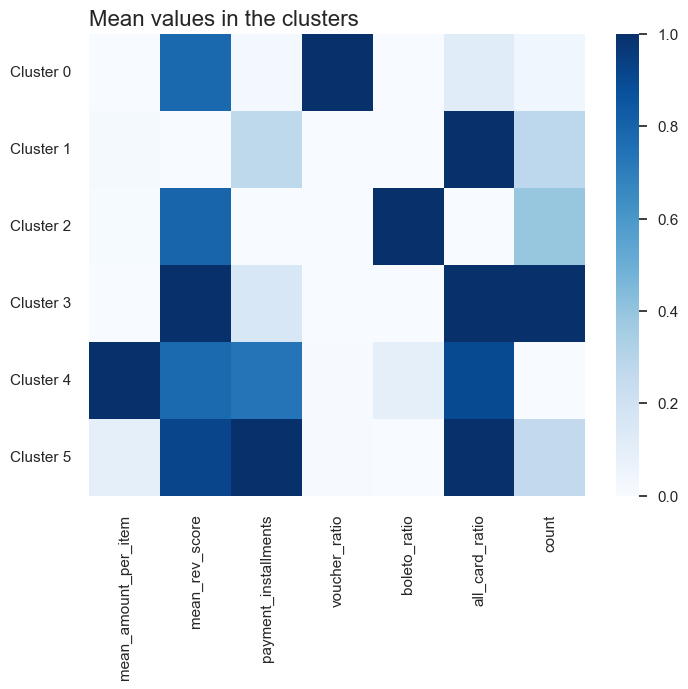

In [87]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sns.set(font_scale=2)
sns.set(rc={'figure.facecolor': 'white'})
fig, ax = plt.subplots()
desc = sns.heatmap(df_desc_sc, vmin=0, vmax=1, cmap="Blues", square=False, ax=ax,
                   cbar_kws={'orientation': 'vertical', 'pad': 0.05, 'shrink': 1.})
desc.set_title('Mean values in the clusters', fontsize=16, loc='left');
desc.set_xticklabels(desc_cols);
desc.set_yticklabels([f"Cluster {c}" for c in df_cust_clusters.index]);
plt.xticks(rotation=90);
plt.yticks(rotation=0);

### Cluster boxplots

In [89]:
yellowbrick.set_aesthetic()

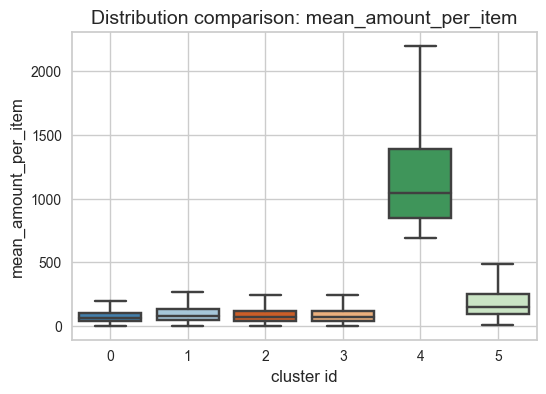

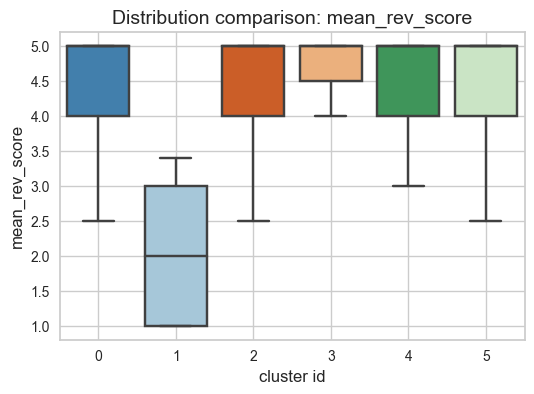

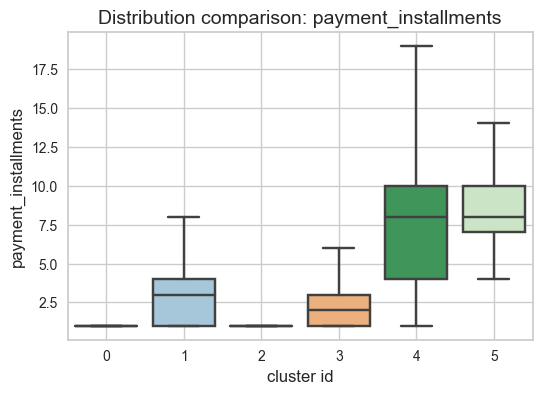

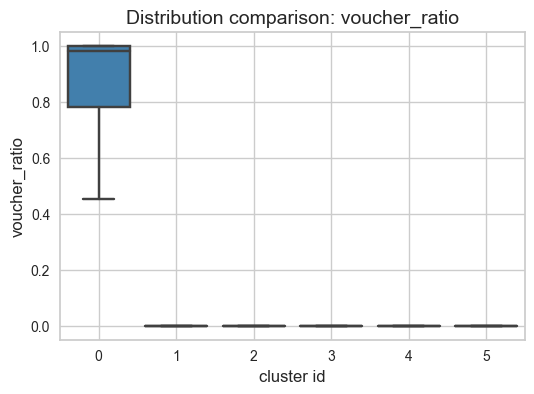

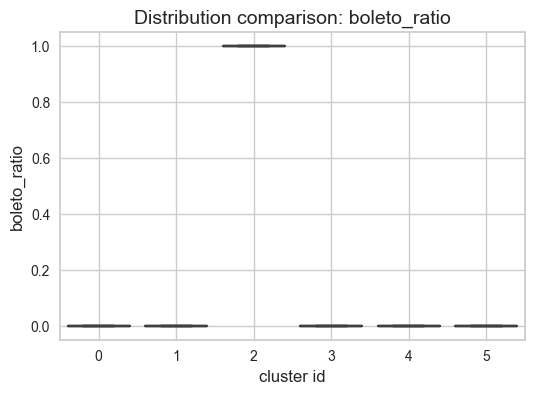

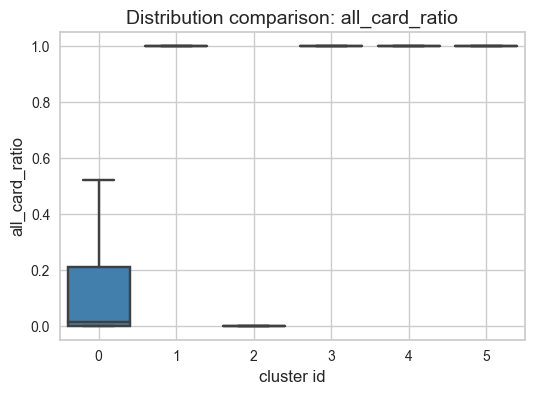

In [92]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
N = 10 #n_clusters #10
plt.rcParams['axes.prop_cycle'] = cycler(color=plt.cm.tab20c(np.linspace(0, 1, N)))
for col in feat_cols:
    f, ax = plt.subplots()
    sns.boxplot(data=df_cust, x='label', y=col, width=0.8, showfliers = False)
    plt.title(f'Distribution comparison: {col}')
    plt.xlabel(f'cluster id')
    plt.ylabel(f'{col}')
    plt.grid('on')

These boxplots justify the abandonment of recency in segmentation.

### Cluster radarplots

In [93]:
feat_cols_2 = feat_cols + [feat_cols[0]]
df_cust_clusters_sc = MinMaxScaler().fit_transform(df_cust_clusters[feat_cols])
df_cust_clusters_sc = np.hstack((df_cust_clusters_sc, df_cust_clusters_sc[:, 0].reshape(-1, 1)))

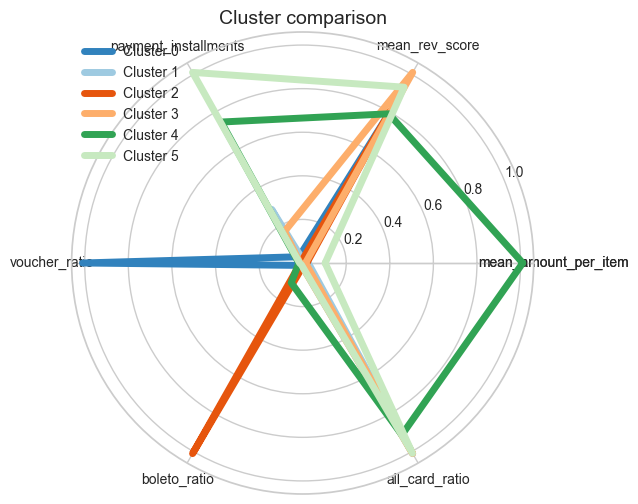

In [96]:
plt.rcParams['figure.figsize'] = [6, 6]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

n = len(feat_cols_2)
all_labels = np.unique(labels_kmeans)
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(feat_cols_2))

plt.figure()
plt.subplot(polar=True)
for lbl in all_labels: #range(2)
    vals = df_cust_clusters_sc[lbl,:]+0.01
    plt.plot(np.array(label_loc), vals, label=f"Cluster {lbl}", linewidth=5)
plt.title('Cluster comparison');
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=feat_cols_2)
plt.legend();
plt.show();

### Visualization in ACP plans

In [101]:
cmaps = [plt.cm.jet] # tab20c

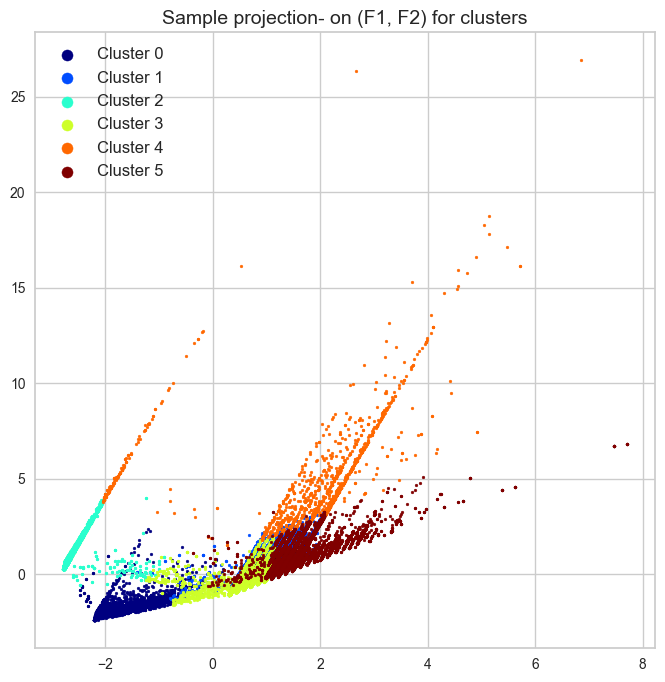

In [103]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
N = n_clusters
for cm in cmaps:
    cmap = cm
    plt.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))
    for label in np.unique(labels_kmeans):
        selected = np.where(labels_kmeans == label)
        plt.scatter(X_proj[selected, 0], X_proj[selected, 1], s=4, label=f"Cluster {label}")
    plt.legend(markerscale=4, prop={'size': 12})
    plt.title('Sample projection- on (F1, F2) for clusters')
    plt.show(block=False)

<img src="Ara.png"/>

### Visualization in the t-SNE plane

In [105]:
HAVE_TIME = True

In [106]:
if HAVE_TIME:
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=1500, init='pca', learning_rate='auto')
    X_tsne = tsne.fit_transform(X_scaled)
    %store X_tsne
else:
    %store -r X_tsne

Stored 'X_tsne' (ndarray)


In [107]:
X_scaled.shape

(94208, 6)

In [108]:
cmaps = [plt.cm.jet] # tab20c

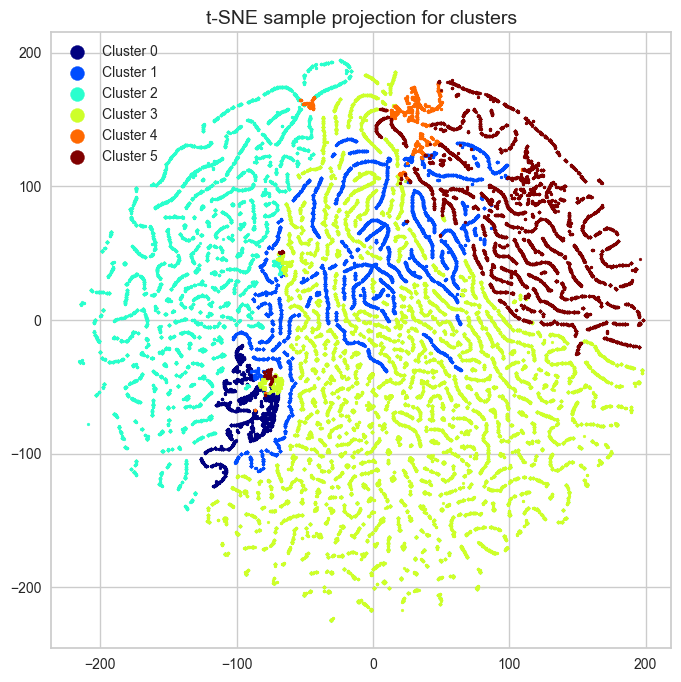

In [111]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
N = n_clusters
for cm in cmaps:
    cmap = cm
    plt.rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))
    for label in np.unique(labels_kmeans):
        selected = np.where(labels_kmeans == label)
        plt.scatter(X_tsne[selected, 0], X_tsne[selected, 1], s=4, label=f"Cluster {label}")
    plt.title('t-SNE sample projection for clusters')
    plt.legend(prop={'size': 10}, markerscale=5)
    plt.show(block=False)

There is a less good separation of individuals than in RFM segmentation.

# Export results

The data useful for the study of the maintenance period are saved.

In [112]:
with open(data_processed_dir+'df_cust.pkl', 'wb') as output:
    pickle.dump(df_cust, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'feat_cols.pkl', 'wb') as output:
    pickle.dump(feat_cols, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'n_clusters.pkl', 'wb') as output:
    pickle.dump(n_clusters, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'scaler.pkl', 'wb') as output:
    pickle.dump(scaler, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'pca.pkl', 'wb') as output:
    pickle.dump(pca, output, pickle.HIGHEST_PROTOCOL)
    
with open(data_processed_dir+'X_tsne.pkl', 'wb') as output:
    pickle.dump(X_tsne, output, pickle.HIGHEST_PROTOCOL)